# Characterize 5'SSs of C branchpoints and branchpoints missing a -2 T

In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)
from scipy.stats import ranksums, fisher_exact
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
bases = ['A', 'C', 'G', 'T']

# Load data

In [2]:
from genome import Genome
genome = Genome('../anno/hg19.fa')

In [3]:
# file is result of bedtools intersect -loj
introns = {}
lengths = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, gene, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end, pos = int(bp), int(start), int(end), int(pos)
        gene = gene.split('.')[0]
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand, gene)
        
        lengths[(chrom, three)] = (end - pos
                                   if strand == '+' else
                                   pos - start)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [4]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [5]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns):
    X, y, chroms, coords, strands, genes = [], [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand, gene = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')
        
        X += [np.hstack([onehot(seq)]).reshape(1, L, 4)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
        genes += [gene]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords),
            np.array(strands), np.array(genes))

(X_known, y_known,
 k_chroms, k_coords,
 k_strands, k_genes) = encode(known)
(X_novel, y_novel, 
 n_chroms, n_coords,
 n_strands, n_genes) = encode(missing)

print np.sum(y_novel), np.sum(y_known)
print X_novel.shape, X_known.shape

0.0 56808.0
(169182, 70, 4) (37110, 70, 4)


In [6]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [7]:
y_novel = model.predict(X_novel[:, :, :4]).reshape(-1, L)
p_known = model.predict(X_known[:, :, :4]).reshape(-1, L)

In [8]:
X_all = np.vstack([X_novel, X_known])
y_all = np.vstack([y_novel, p_known])
a_chroms  = np.hstack([n_chroms,  k_chroms])
a_coords  = np.hstack([n_coords,  k_coords])
a_strands = np.hstack([n_strands, k_strands])
a_genes = np.hstack([n_genes, k_genes])

In [9]:
# chr1	135802	135902	ENSG00000237683.5:ENST00000423372.3:AL627309.1	137620	-
fives = {}
with open('../preprocessing/gencode.v19.introns.bpregion.bed') as fp:
    for line in fp:
        chrom, start, end, name, five, strand = line.strip().split()
        if strand not in fives: fives[strand] = {}
        if chrom not in fives[strand]: fives[strand][chrom] = {}
        three = int(end if strand == '+' else start)
        fives[strand][chrom][three] = int(five)

In [10]:
def parse(line):
    chrom, source, feature, start, end, _, strand, _, info = line.strip().split('\t')
    info = {el.split(' ')[0].strip('"'): el.split(' ')[1].strip('"')
            for el in info.strip(';').split('; ')}
    start, end = int(start)-1, int(end) # bed coordinates
    return chrom, feature, start, end, strand, info

down_fives = {}
with open('../anno/gencode.v19.annotation.gtf') as fp:
    for line in fp:
        if line[0] == '#': continue
        chrom, feature, start, end, strand, info = parse(line)
        if 'gene_type' not in info or info['gene_type'] != 'protein_coding': continue
        if 'transcript_type' not in info or info['transcript_type'] != 'protein_coding': continue

        if feature == 'transcript':
            cur_transcript = info['transcript_id']
            last_exon = None

        elif feature == 'exon':
            assert info['transcript_id'] == cur_transcript
            if last_exon:
                if strand not in down_fives: down_fives[strand] = {}
                if chrom not in down_fives[strand]: down_fives[strand][chrom] = {}
                down_fives[strand][chrom][last_exon[0]] = last_exon[1]
            if strand == '+':
                last_exon = (start, end)
            else:
                last_exon = (end, start)

In [11]:
from MaxEntScan.maxentscan import maxentscan
length = 20
a_down_fives, down_seqs = [], []
for strand, chrom, three in zip(a_strands, a_chroms, a_coords):
    if strand == '-':
        seq = 'A'*length*2
        a_down_fives += [onehot(seq).reshape(1, -1, 4)]
        down_seqs += [seq[length-3:length+6+1]]
    if three not in down_fives[strand][chrom]: continue
    five = down_fives[strand][chrom][three]
    seq = genome.get_seq(chrom, five-length, five +length, strand)
    a_down_fives += [onehot(seq).reshape(1, -1, 4)]
    down_seqs += [seq[length-3:length+6+1]]
a_down_fives = np.vstack(a_down_fives)

In [12]:
down_scan = maxentscan(down_seqs, True)

In [13]:
from MaxEntScan.maxentscan import maxentscan
length = 20
a_fives, seqs = [], []
for strand, chrom, three in zip(a_strands, a_chroms, a_coords):
    five = fives[strand][chrom][three]
    seq = genome.get_seq(chrom, five-length, five +length, strand)
    a_fives += [onehot(seq).reshape(1, -1, 4)]
    seqs += [seq[length-3:length+6+1]]
a_fives = np.vstack(a_fives)

In [14]:
scan = maxentscan(seqs, True)

In [15]:
from scipy.stats import ttest_ind

K = 10
def pwm(X):
    return X.mean(axis = 0)[:, :4]

def information(pwm):
    return 2*pwm.shape[0] + np.sum(pwm * np.log2(pwm))

def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

def pwm_logo(pwm, title, x=None, aspect = 2.5):
    fig = plt.figure(figsize=(10,5))
    adjustFigAspect(fig,aspect=aspect)

    ax = fig.add_subplot(111)
    #f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'U'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax.bar(bar_l,
               pwm[:, i],
               width=bar_width,
               label=char,
               bottom=np.sum(pwm[:, :i], axis = 1),
               alpha=0.5,
               color = color)
    plt.xticks(tick_pos, x if x else range(-K, K+1))
    plt.legend(loc = 1, prop={'size':9})
    plt.title(title)
    plt.ylim(0, 1)
    plt.xlim(.75, len(x)+1 if x else 2*K+2)
    plt.show()
    
def info(idx1, idx2, title1, title2, fives_onehot, fives_scan):
    print len(idx1), len(idx2)
    
    pwm1, pwm2 = pwm(fives_onehot[idx1]), pwm(fives_onehot[idx2])

    pwm_logo(pwm1, title1, range(-20, 20), 6)
    pwm_logo(pwm2, title2, range(-20, 20), 6)
    print title1, 'information=', information(pwm1)
    print title2, 'information=', information(pwm2)
    print title1, 'information9=', information(pwm1[length-3:length+6+1])
    print title2, 'information9=', information(pwm2[length-3:length+6+1])
    print title1, 'maxentscan=', np.mean(fives_scan[idx1])
    print title2, 'maxentscan=', np.mean(fives_scan[idx2])
    print ttest_ind(fives_scan[idx1], fives_scan[idx2])
    
    for i in range(4):
        plt.plot(pwm1[:, i] - pwm2[:, i], label = bases[i])
    plt.legend()
    plt.title(title1 + '-' + title2)
    plt.show()

3347 202549


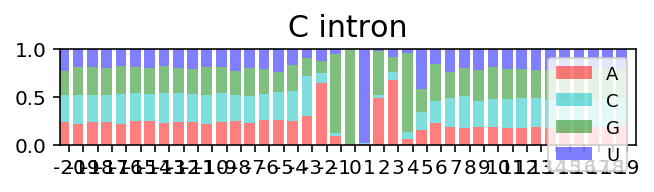

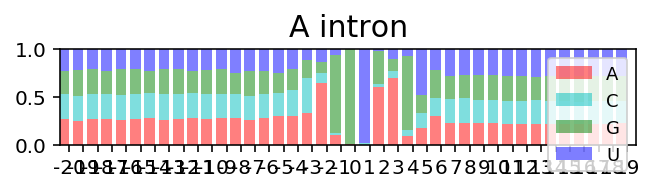

C intron information= 8.78872438483
A intron information= 8.14477689516
C intron information9= 8.03584051586
A intron information9= 7.95940906098
C intron maxentscan= 7.84909471168
A intron maxentscan= 8.11495638093
Ttest_indResult(statistic=-5.1455442764262802, pvalue=2.6699031819792452e-07)


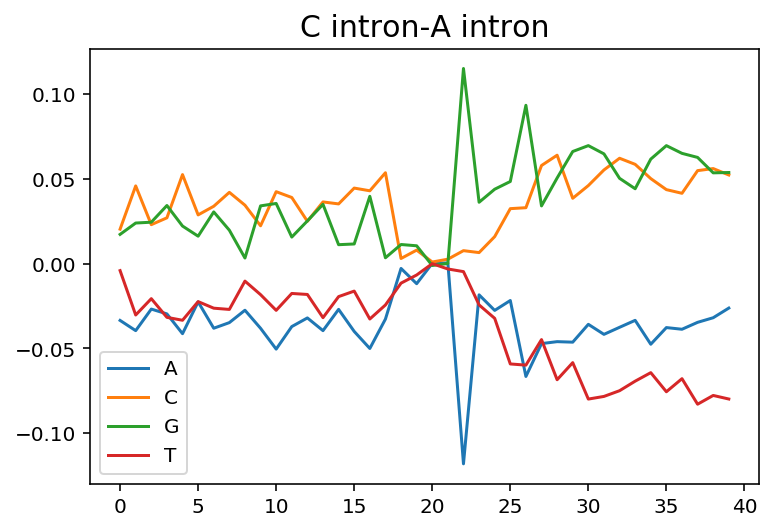

In [16]:
C = []
for i, (target, seq) in enumerate(zip(y_all, X_all)):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    if not seq[bp, 1]: continue
    C += [i]
    
A = []
for i, (target, seq) in enumerate(zip(y_all, X_all)):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    if not seq[bp, 0]: continue
    A += [i]

info(C, A, 'C intron', 'A intron', a_fives, scan)

2121 129411


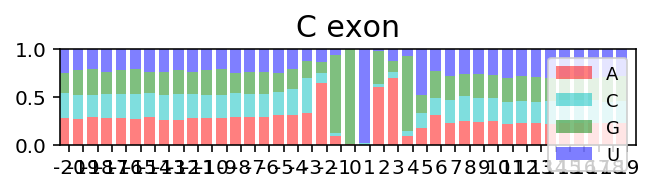

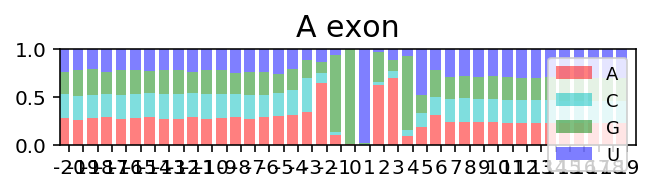

C exon information= 8.15900769044
A exon information= 8.15408909716
C exon information9= 7.94341970338
A exon information9= 7.93141738669
C exon maxentscan= 8.10205091938
A exon maxentscan= 8.07238387772
Ttest_indResult(statistic=0.47119136195091177, pvalue=0.63750486818607832)


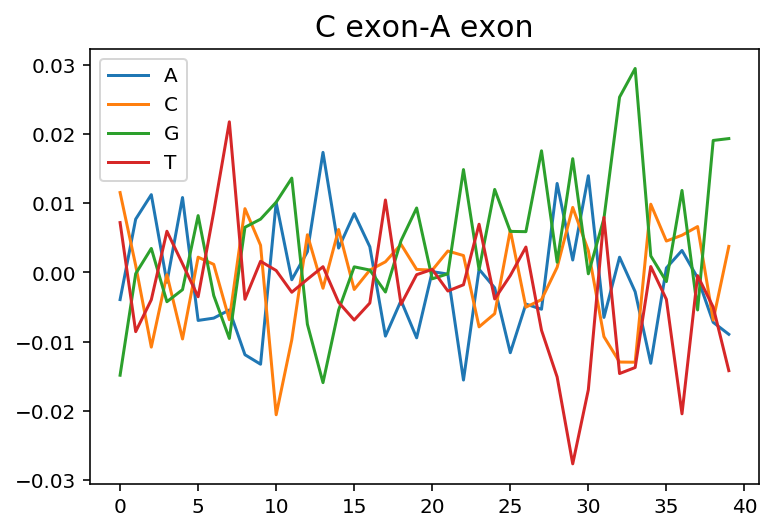

In [17]:
C = []
for i, (target, seq, mes) in enumerate(zip(y_all, X_all, down_scan)):
    if mes == -15.19: continue
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    if not seq[bp, 1]: continue
    C += [i]
    
A = []
for i, (target, seq, mes) in enumerate(zip(y_all, X_all, down_scan)):
    if mes == -15.19: continue
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    if not seq[bp, 0]: continue
    A += [i]
info(C, A, 'C exon', 'A exon', a_down_fives, down_scan)

38850 167172


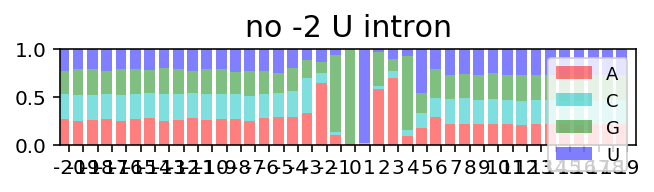

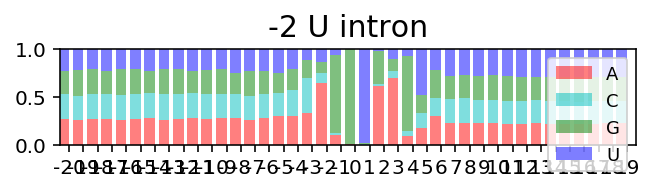

no -2 U intron information= 8.02558711397
-2 U intron information= 8.17693699748
no -2 U intron information9= 7.83777864444
-2 U intron information9= 7.98758488632
no -2 U intron maxentscan= 7.95757323037
-2 U intron maxentscan= 8.14556827698
Ttest_indResult(statistic=-11.248419892402378, pvalue=2.4047478774009806e-29)


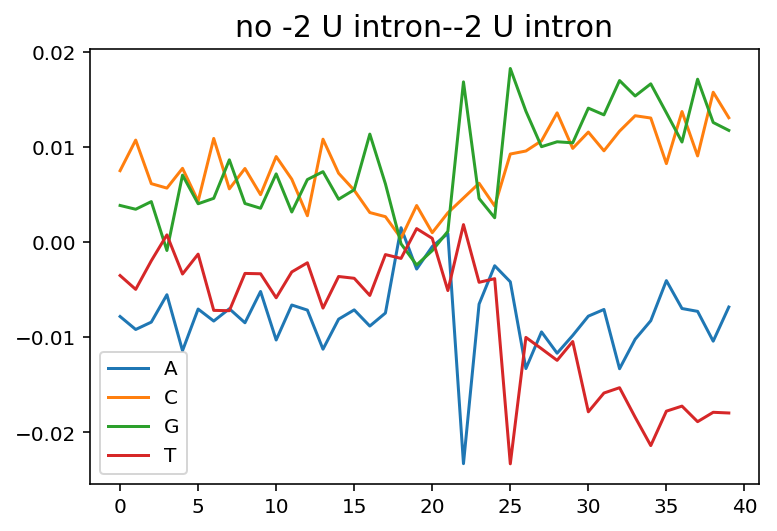

In [18]:
U = []
for i, (target, seq) in enumerate(zip(y_all, X_all)):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    if not seq[bp-2, 3]: continue
    U += [i]
    
noU = []
for i, (target, seq) in enumerate(zip(y_all, X_all)):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    if seq[bp-2, 3]: continue
    noU += [i]
info(noU, U, 'no -2 U intron', '-2 U intron', a_fives, scan)

24744 106864


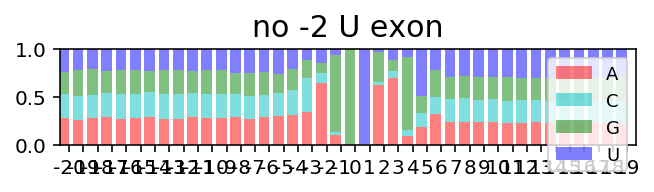

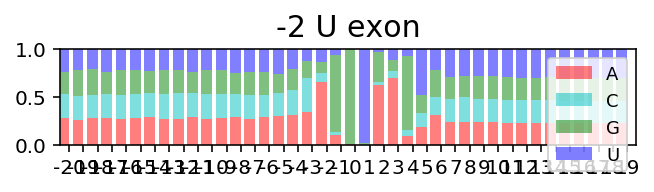

no -2 U exon information= 8.14785162446
-2 U exon information= 8.15570671241
no -2 U exon information9= 7.92722493568
-2 U exon information9= 7.9327659449
no -2 U exon maxentscan= 8.06476842871
-2 U exon maxentscan= 8.07485046414
Ttest_indResult(statistic=-0.49693268228205423, pvalue=0.61923735361959009)


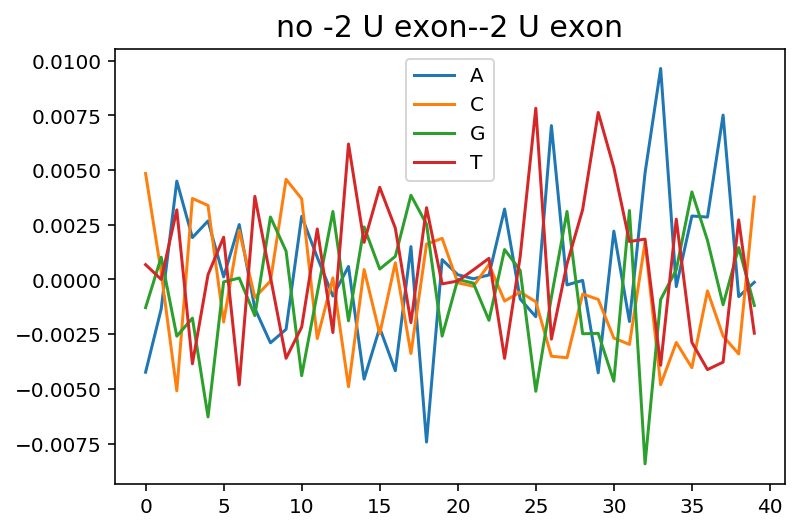

In [19]:
U = []
for i, (target, seq, mes) in enumerate(zip(y_all, X_all, down_scan)):
    if mes == -15.19: continue
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    if not seq[bp-2, 3]: continue
    U += [i]
    
noU = []
for i, (target, seq, mes) in enumerate(zip(y_all, X_all, down_scan)):
    if mes == -15.19: continue
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    if seq[bp-2, 3]: continue
    noU += [i]

info(noU, U, 'no -2 U exon', '-2 U exon', a_down_fives, down_scan)